In [1]:
!uv pip install kagglehub

Using Python 3.11.6 environment at: /Users/nyeinchan/Desktop/time-series/.venv
Audited 1 package in 29ms


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import kagglehub

import os

os.environ['NIXTLA_ID_AS_COL'] = '1'
plt.rcParams['axes.grid'] = True

/Users/nyeinchan/Desktop/time-series/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from pandas.tseries.holiday import USFederalHolidayCalendar

from statsforecast import StatsForecast
from mlforecast import MLForecast
from utilsforecast.losses import mae, rmse, smape
from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series

from window_ops.rolling import rolling_mean, rolling_std

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [4]:
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

dataset = "COMED_hourly.csv"

df = pd.read_csv(f'{path}/{dataset}')
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 66497 entries, 0 to 66496
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  66497 non-null  str    
 1   COMED_MW  66497 non-null  float64
dtypes: float64(1), str(1)
memory usage: 2.2 MB


In [5]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime').reset_index(drop=True)

df.head(10)

,Datetime,COMED_MW
0,2011-01-01 01:00:00,9631.0
1,2011-01-01 02:00:00,9273.0
2,2011-01-01 03:00:00,9011.0
3,2011-01-01 04:00:00,8741.0
4,2011-01-01 05:00:00,8694.0
5,2011-01-01 06:00:00,8711.0
6,2011-01-01 07:00:00,8943.0
7,2011-01-01 08:00:00,9222.0
8,2011-01-01 09:00:00,9430.0
9,2011-01-01 10:00:00,9670.0


In [6]:
df['ds'] = pd.to_datetime(df['Datetime'])
df = df.rename(columns={'COMED_MW': 'y'})
df['unique_id'] = 'comed_hourly'
df = df[['unique_id', 'ds', 'y']]

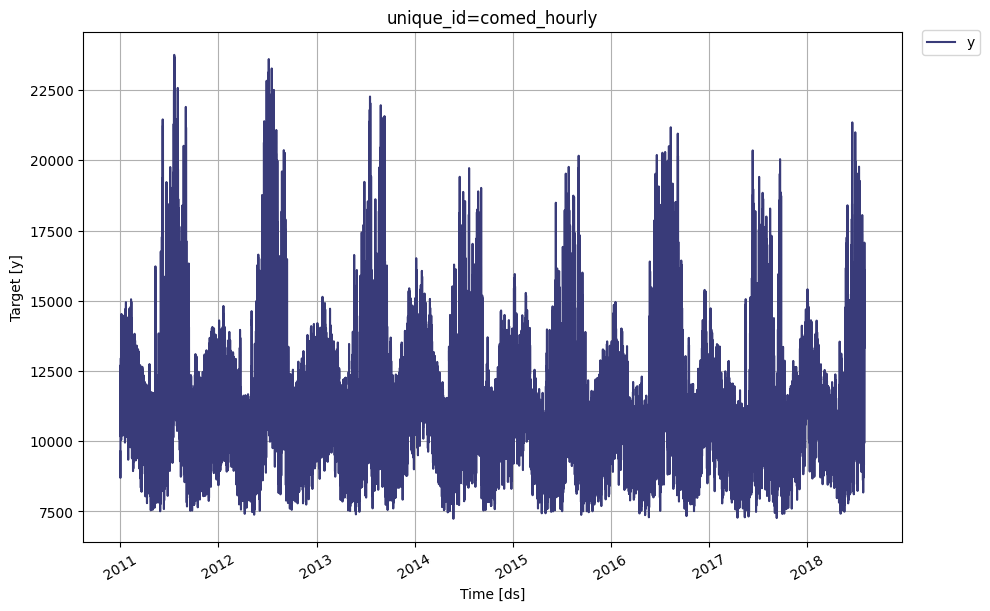

In [7]:
f = StatsForecast.plot(df)
f.set_figwidth(9)
f.set_figheight(6)
f


Handle DST issues just like in stats notebook

In [8]:
df[df['ds'].duplicated(keep=False)].sort_values('ds')

,unique_id,ds,y
33618,comed_hourly,2014-11-02 02:00:00,9184.0
33619,comed_hourly,2014-11-02 02:00:00,8869.0
42354,comed_hourly,2015-11-01 02:00:00,8270.0
42355,comed_hourly,2015-11-01 02:00:00,7923.0
51258,comed_hourly,2016-11-06 02:00:00,8028.0
51259,comed_hourly,2016-11-06 02:00:00,7814.0
59994,comed_hourly,2017-11-05 02:00:00,8198.0
59995,comed_hourly,2017-11-05 02:00:00,7878.0


In [9]:
dst_times = [
    "2014-11-02 02:00:00",
    "2015-11-01 02:00:00",
    "2016-11-06 02:00:00",
    "2017-11-05 02:00:00",
]

for t in dst_times:
    t = pd.Timestamp(t)

    rows = df[df['ds'] == t]

    combined_y = rows['y'].sum() / 2

    # keep the first row
    keep_idx = rows.index[0]
    drop_idx = rows.index[1]

    df.loc[keep_idx, 'y'] = combined_y
    df = df.drop(drop_idx)


full_range = pd.DataFrame({'ds': pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='h')})

df = full_range.merge(df, on='ds', how='left')
df['unique_id'] = df['unique_id'].ffill()

df['y'] = df['y'].interpolate(method='linear')

In [10]:
len(df)

66504

### Feature Engineering

Since comparing baseline methods with statistical methods.\
SeasonalNaive_Daily is has the highest accruacy and it means\
Today at 3pm ~= Yesterday at 3pm

`residual_24_hour = y_t - y_t-24`

Also weekly pattern

`residual_168_hour = y_t - y_t-168`

Also pattern deviation weekly

`residual_168_24 = (y_t - y_t-24) - (y_t-168 - y_t-192)`

<br>

List of features that will be added
- Residual features + Lag features
- Rolling statistics 24, 168
- Calendar Features
- Fourier terms - optional

In [11]:
# residual features
# not-peeking ahead no leakage
df['residual_24'] = df['y'] - df['y'].shift(24)
df['residual_168'] = df['y'] - df['y'].shift(168)
df['residual_168_24'] = (df['y'] - df['y'].shift(24)) - (df['y'].shift(168) - df['y'].shift(192))

In [12]:
# calendar features
df['hour'] = df['ds'].dt.hour
df['dayofweek'] = df['ds'].dt.day_of_week
df['month'] = df['ds'].dt.month
df['is_weekend'] = (df['ds'].dt.day_of_week >= 5).astype(int)

cal = USFederalHolidayCalendar()
us_holidays = cal.holidays(start=df['ds'].min(), end=df['ds'].max())
ds_norm = df['ds'].dt.normalize()

df['is_holiday'] = ds_norm.isin(us_holidays).astype(int)
df['is_day_before_holiday'] = ds_norm.isin(us_holidays - pd.Timedelta(days=1)).astype(int)
df['is_day_after_holiday']  = ds_norm.isin(us_holidays + pd.Timedelta(days=1)).astype(int)

In [13]:
# fourier harmonics for annual cycle
day_of_year = df['ds'].dt.dayofyear
for k in range(1, 4):
    # k=3 cycles per year
    df[f'sin_annual_{k}'] = np.sin(2 * np.pi * k * day_of_year / 365.25)
    df[f'cos_annual_{k}'] = np.cos(2 * np.pi * k * day_of_year / 365.25)

In [14]:
# drop nan-values from first shifts
df_clean = df.dropna().reset_index(drop=True)

test_size = 24 * 14
train_ml = df_clean.iloc[:-test_size]
test_ml  = df_clean.iloc[-test_size:]

In [15]:
test_ml.head()

,ds,unique_id,y,residual_24,residual_168,residual_168_24,hour,dayofweek,month,is_weekend,is_holiday,is_day_before_holiday,is_day_after_holiday,sin_annual_1,cos_annual_1,sin_annual_2,cos_annual_2,sin_annual_3,cos_annual_3
65976,2018-07-20 01:00:00,comed_hourly,12682.0,1593.0,-675.0,951.0,1,4,7,0,0,0,0,-0.310857,-0.950457,0.590912,0.806736,-0.812416,-0.583078
65977,2018-07-20 02:00:00,comed_hourly,11929.0,1598.0,-367.0,1052.0,2,4,7,0,0,0,0,-0.310857,-0.950457,0.590912,0.806736,-0.812416,-0.583078
65978,2018-07-20 03:00:00,comed_hourly,11327.0,1536.0,-291.0,964.0,3,4,7,0,0,0,0,-0.310857,-0.950457,0.590912,0.806736,-0.812416,-0.583078
65979,2018-07-20 04:00:00,comed_hourly,10895.0,1473.0,-181.0,910.0,4,4,7,0,0,0,0,-0.310857,-0.950457,0.590912,0.806736,-0.812416,-0.583078
65980,2018-07-20 05:00:00,comed_hourly,10676.0,1467.0,-33.0,989.0,5,4,7,0,0,0,0,-0.310857,-0.950457,0.590912,0.806736,-0.812416,-0.583078


In [16]:
exogeneous_features = [
    'residual_24', 'residual_168', 'residual_168_24',
    'hour', 'dayofweek', 'month', 'is_weekend',
    'is_holiday', 'is_day_before_holiday', 'is_day_after_holiday',
    'sin_annual_1', 'cos_annual_1',
    'sin_annual_2', 'cos_annual_2',
    'sin_annual_3', 'cos_annual_3',
]

mlf = MLForecast(
    models={
        'xgboost': XGBRegressor(n_estimators=500, learning_rate=0.01, verbosity=0),
        'catboost': CatBoostRegressor(iterations=500, learning_rate=0.01, verbose=0, loss_function='RMSE'),
        'lgbm': LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=0),
    },
    freq='h',
    lags=[1, 2, 24, 48, 168, 336],
    lag_transforms={
        24: [(rolling_mean, 24), (rolling_std, 24)],
        168: [(rolling_mean, 168), (rolling_std, 168)],
    },
)

mlf.fit(train_ml[['unique_id', 'ds', 'y'] + exogeneous_features], static_features=[])


# predict
future_exog = test_ml[['unique_id', 'ds'] + exogeneous_features]
preds = mlf.predict(h=336, X_df=future_exog)

preds

,unique_id,ds,xgboost,catboost,lgbm
0,comed_hourly,2018-07-20 01:00:00,12586.645508,12726.297719,12740.819498
1,comed_hourly,2018-07-20 02:00:00,11737.876953,11917.207157,11976.756854
2,comed_hourly,2018-07-20 03:00:00,11184.480469,11271.551777,11357.321221
3,comed_hourly,2018-07-20 04:00:00,10767.438477,10756.495414,10979.352896
4,comed_hourly,2018-07-20 05:00:00,10569.397461,10514.869997,10758.339269
...,...,...,...,...,...
331,comed_hourly,2018-08-02 20:00:00,15352.582031,14786.655730,14909.380496
332,comed_hourly,2018-08-02 21:00:00,14857.469727,14599.977069,14468.237967
333,comed_hourly,2018-08-02 22:00:00,14449.210938,14433.511445,14132.252267
334,comed_hourly,2018-08-02 23:00:00,14010.196289,14000.352742,13719.096701


In [17]:
cv_ml = mlf.cross_validation(
    df=train_ml[['unique_id', 'ds', 'y'] + exogeneous_features],
    h=336,
    n_windows=5,
    step_size=336,
    static_features=[]
)

cross-validation

In [18]:
eval_ml = evaluate(
    cv_ml,
    metrics=[mae, rmse],
    models=['xgboost', 'catboost', 'lgbm']
)

eval_ml

,unique_id,cutoff,metric,xgboost,catboost,lgbm
0,comed_hourly,2018-05-11,mae,286.310281,436.478850,317.343275
1,comed_hourly,2018-05-25,mae,721.398028,984.266762,679.457270
2,comed_hourly,2018-06-08,mae,642.522625,903.266500,765.024659
3,comed_hourly,2018-06-22,mae,950.808036,1307.518692,1128.044829
4,comed_hourly,2018-07-06,mae,1207.552444,1208.206294,1590.058418
5,comed_hourly,2018-05-11,rmse,334.033844,515.979397,371.790333
6,comed_hourly,2018-05-25,rmse,881.830573,1265.852939,867.209506
7,comed_hourly,2018-06-08,rmse,930.807260,1304.051369,1110.660746
8,comed_hourly,2018-06-22,rmse,1299.364609,1780.402325,1536.482609
9,comed_hourly,2018-07-06,rmse,1552.982910,1597.871674,2020.953047


- summer spikes are harder to predict even for tree-based models
- adding weather | temperature features might improve a bit

In [19]:
eval_ml[eval_ml['metric'] == 'rmse'].drop(columns=['unique_id','metric','cutoff']).mean().sort_values()

xgboost      999.803839
lgbm        1181.419248
catboost    1292.831541
dtype: float64

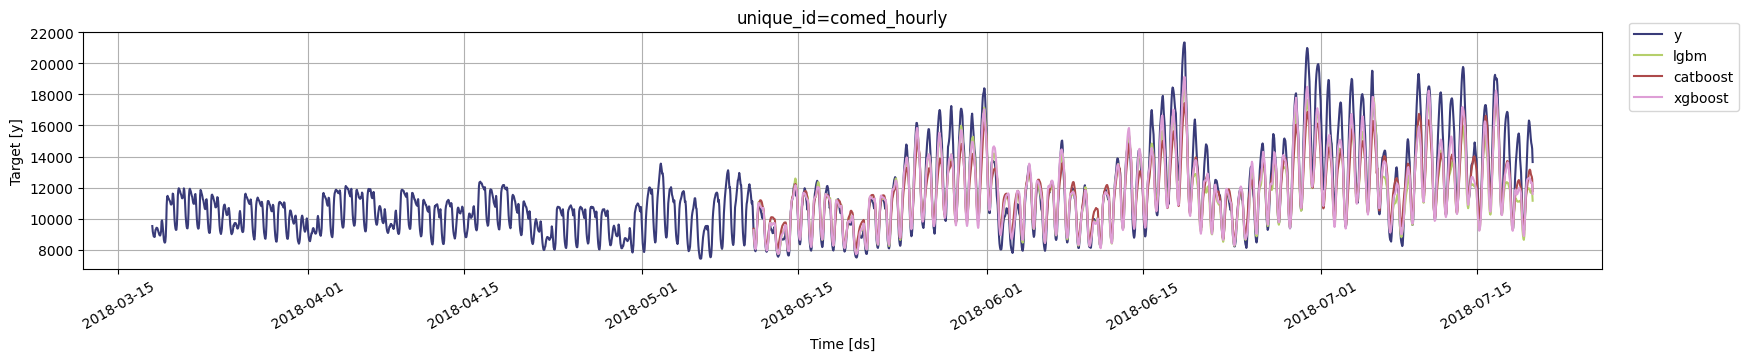

In [20]:
# comparing across 5 folds
StatsForecast.plot(
    train_ml[63000:],
    cv_ml[
        [
            'unique_id', 'ds', 
            'lgbm',
            'catboost',
            'xgboost',
        ]
    ]
)

Evaluation on splitted test set\
14 days | 336 hours

In [21]:
# merge predictions with actual test values
eval_df = test_ml[['unique_id', 'ds', 'y']].merge(
    preds,
    on=['unique_id', 'ds'],
    how='left'
)

eval_df

,unique_id,ds,y,xgboost,catboost,lgbm
0,comed_hourly,2018-07-20 01:00:00,12682.0,12586.645508,12726.297719,12740.819498
1,comed_hourly,2018-07-20 02:00:00,11929.0,11737.876953,11917.207157,11976.756854
2,comed_hourly,2018-07-20 03:00:00,11327.0,11184.480469,11271.551777,11357.321221
3,comed_hourly,2018-07-20 04:00:00,10895.0,10767.438477,10756.495414,10979.352896
4,comed_hourly,2018-07-20 05:00:00,10676.0,10569.397461,10514.869997,10758.339269
...,...,...,...,...,...,...
331,comed_hourly,2018-08-02 20:00:00,16437.0,15352.582031,14786.655730,14909.380496
332,comed_hourly,2018-08-02 21:00:00,15590.0,14857.469727,14599.977069,14468.237967
333,comed_hourly,2018-08-02 22:00:00,15086.0,14449.210938,14433.511445,14132.252267
334,comed_hourly,2018-08-02 23:00:00,14448.0,14010.196289,14000.352742,13719.096701


In [22]:
final_eval_ml = evaluate(
    eval_df,
    metrics=[mae, rmse],
    models=['xgboost', 'catboost', 'lgbm']
)

final_eval_ml

,unique_id,metric,xgboost,catboost,lgbm
0,comed_hourly,mae,567.452108,717.914866,660.825574
1,comed_hourly,rmse,804.194086,1008.726545,889.680661


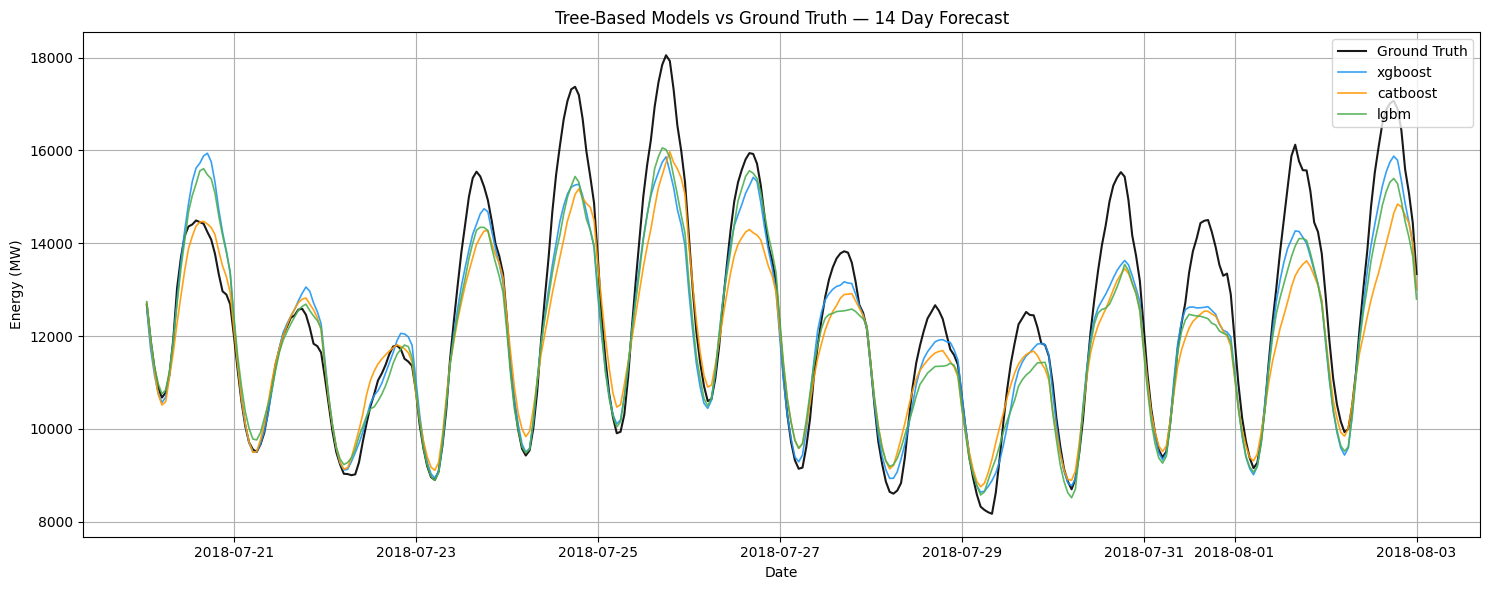

In [31]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(eval_df['ds'], eval_df['y'], label='Ground Truth', color='black', linewidth=1.5, alpha=0.9)

colors = {'xgboost': '#2196F3', 'catboost': '#FF9800', 'lgbm': '#4CAF50'}
for model, color in colors.items():
    ax.plot(eval_df['ds'], eval_df[model], label=f'{model}', color=color, linewidth=1.2, linestyle='-', alpha=0.9)

ax.set_title('Tree-Based Models vs Ground Truth — 14 Day Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Energy (MW)')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

Forecast hourly consumption two weeks ahead. 

In [ ]:
mlf_final = MLForecast(
    models={
        'xgboost': XGBRegressor(n_estimators=500, learning_rate=0.01, verbosity=0),
        'catboost': CatBoostRegressor(iterations=500, learning_rate=0.01, verbose=0, loss_function='RMSE'),
        'lgbm': LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=0),
    },
    freq='h',
    lags=[1, 2, 24, 48, 168, 336],
    lag_transforms={
        24: [(rolling_mean, 24), (rolling_std, 24)],
        168: [(rolling_mean, 168), (rolling_std, 168)],
    },
)

mlf_final.fit(df_clean[['unique_id', 'ds', 'y'] + exogeneous_features], static_features=[])